In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

14189


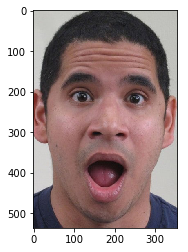

In [2]:
raw1 = np.loadtxt('data/legend.csv', dtype='S50', delimiter=',').astype(str)
raw1 = raw1[2:, :]
raw2 = np.loadtxt('data/500_picts_satz.csv', dtype='S50', delimiter=',').astype(str)
raw = np.vstack((raw1, raw2))
N = raw.shape[0]
print(N)

clusters = raw[:, 0]
filenames = np.vectorize(lambda x: 'images/' + x)(raw[:, 1])
labels = np.vectorize(lambda x: x.lower())(raw[:, 2])
dic, idx = np.unique(labels, return_inverse=True)
labels = np.zeros((N, dic.shape[0]))
labels[np.arange(N), idx] = 1

img = mpimg.imread(filenames[0])
plt.imshow(img)
plt.show()

In [3]:
img_size = 30
batch_size = 200
num_classes = dic.shape[0]
num_steps = 2000
display_step = 100
dropout = 0.75 # Dropout, probability to keep units
learning_rate = 1e-3

In [4]:
def preprocessing(filename, label):
    image_string = tf.read_file(filename)
    image_decode = tf.cond(
        tf.image.is_jpeg(image_string),
        lambda: tf.image.decode_jpeg(image_string, channels=1),
        lambda: tf.image.decode_png(image_string, channels=1))
    image_resize = tf.image.resize_images(image_decode, [img_size * img_size, 1])
    image = tf.squeeze(tf.cast(image_resize, tf.float32))
    return image, label

sess = tf.Session()

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(preprocessing)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(batch_size)
iterator = dataset.make_initializable_iterator()
sess.run(iterator.initializer)

X, Y = iterator.get_next()

In [5]:
# Create model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, img_size, img_size, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out

# Create a graph for training
logits_train = conv_net(X, num_classes, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights, but has
# different behavior for 'dropout' (not applied).
logits_test = conv_net(X, num_classes, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Run the initializer
sess.run(init)

# Training cycle
for step in range(1, num_steps + 1):

    # Run optimization
    sess.run(train_op)

    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        # (note that this consume a new batch of data)
        loss, acc = sess.run([loss_op, accuracy])
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Optimization Finished!")

Step 1, Minibatch Loss= 78.0094, Training Accuracy= 0.575
Step 100, Minibatch Loss= 1.3397, Training Accuracy= 0.475


KeyboardInterrupt: 